
----- Evaluating LINEAR Model -----
Model: linear
Accuracy: 0.0864


----- Evaluating LOGISTIC Model -----
Model: logistic
Accuracy: 0.9636


----- Evaluating DECISION_TREE Model -----
Model: decision_tree
Accuracy: 0.9864



/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


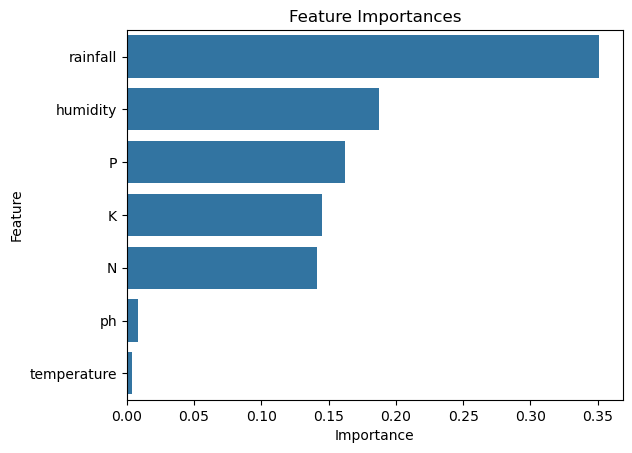


----- Evaluating RANDOM_FOREST Model -----
Model: random_forest
Accuracy: 0.9932



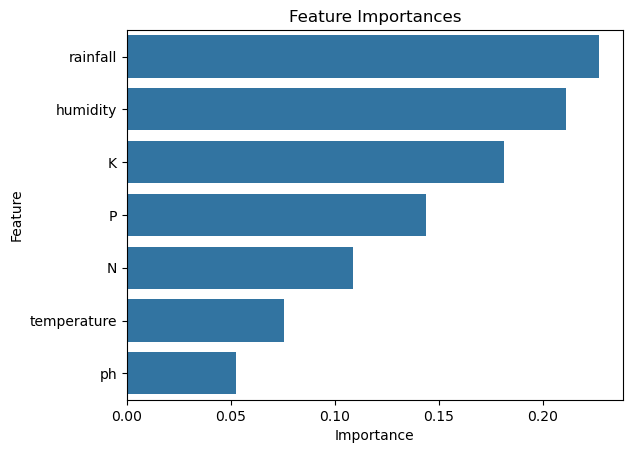


----- Evaluating SVM Model -----
Model: svm
Accuracy: 0.9682



In [34]:
# Crop Recommendation Project - Structured Version
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LinearRegression, LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

class CropRecommendationModel:
    def __init__(self, model_name='decision_tree'):
        self.model_name = model_name
        self.model = None
        self.scaler = StandardScaler()
        self.encoder = LabelEncoder()
        self.X_train = None
        self.X_test = None
        self.y_train = None
        self.y_test = None

    def load_data(self, filepath):
        df = pd.read_csv(filepath)
        X = df.drop('label', axis=1)
        y = self.encoder.fit_transform(df['label'])
        return X, y

    def preprocess(self, X, y, use_pca=False, n_components=None):
        X_scaled = self.scaler.fit_transform(X)
        if use_pca and n_components:
            pca = PCA(n_components=n_components)
            X_scaled = pca.fit_transform(X_scaled)
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

    def train_model(self):
        if self.model_name == 'linear':
            self.model = LinearRegression()
        elif self.model_name == 'logistic':
            self.model = LogisticRegression(max_iter=2000)
        elif self.model_name == 'decision_tree':
            self.model = DecisionTreeClassifier(random_state=42)
        elif self.model_name == 'random_forest':
            self.model = RandomForestClassifier(random_state=42)
        elif self.model_name == 'svm':
            self.model = SVC()
        elif self.model_name == 'sgd':
            self.model = SGDClassifier(random_state=42)

        self.model.fit(self.X_train, self.y_train)

    def evaluate_model(self):
        y_pred = self.model.predict(self.X_test)
    
        # Handle regression models
        if isinstance(self.model, LinearRegression):
            # Convert y_test and y_pred to integers if needed
            if isinstance(self.y_train[0], str):
                le = LabelEncoder()
                le.fit(np.concatenate([self.y_train, self.y_test]))
                self.y_test = le.transform(self.y_test)
                y_pred = le.transform(np.round(y_pred).astype(int))  # Optional mapping
            else:
                y_pred = np.round(y_pred).astype(int)
    
        accuracy = accuracy_score(self.y_test, y_pred)
        report = classification_report(self.y_test, y_pred)
        print(f"Model: {self.model_name}\nAccuracy: {accuracy:.4f}\n")
        # print("Classification Report:\n", report)
   
    def predict_crop(self, input_data: dict):
        import pandas as pd
        df = pd.DataFrame([input_data])
        df_scaled = self.scaler.transform(df)
        pred = self.model.predict(df_scaled)
        crop = self.encoder.inverse_transform(pred)
        return crop[0]

    def get_feature_importance(self, feature_names):
        if hasattr(self.model, 'feature_importances_'):
            importances = self.model.feature_importances_
            importance_df = pd.DataFrame({
                'Feature': feature_names,
                'Importance': importances
            }).sort_values(by='Importance', ascending=False)
            sns.barplot(x='Importance', y='Feature', data=importance_df)
            plt.title('Feature Importances')
            plt.show()
        else:
            print("This model does not support feature importances.")

# Example usage
if __name__ == '__main__':
    model_names = ['linear', 'logistic', 'decision_tree', 'random_forest', 'svm']
    filepath = 'Crop_recommendation.csv'

    for name in model_names:
        print(f"\n----- Evaluating {name.upper()} Model -----")
        crop_model = CropRecommendationModel(model_name=name)
        X, y = crop_model.load_data(filepath)
        crop_model.preprocess(X, y, use_pca=False)
        crop_model.train_model()
        crop_model.evaluate_model()
        if name in ['decision_tree', 'random_forest']:
            crop_model.get_feature_importance(feature_names=X.columns)

# def predict_crop(self, input_data: dict):
#         import pandas as pd
#         df = pd.DataFrame([input_data])
#         df_scaled = self.scaler.transform(df)
#         pred = self.model.predict(df_scaled)
#         crop = self.encoder.inverse_transform(pred)
#         return crop[0]


In [20]:
# === Crop Prediction Based on User Input ===
model = CropRecommendationModel(model_name='random_forest')  # You can change model here
X, y = model.load_data('Crop_recommendation.csv')
model.preprocess(X, y)
model.train_model()

# Input from user (including ph now)
season = input("Enter season (for Step 2 use only): ")

user_input = {
    'N': float(input("Enter value for N: ")),
    'P': float(input("Enter value for P: ")),
    'K': float(input("Enter value for K: ")),
    'temperature': float(input("Enter temperature (°C): ")),
    'humidity': float(input("Enter humidity (%): ")),
    'ph': float(input("Enter soil pH: ")),
    'rainfall': float(input("Enter rainfall (mm): "))
}

predicted_crop = model.predict_crop(user_input)
print(f"\n🌱 Recommended Crop for Given Inputs: {predicted_crop}")
print(f"📅 Season (for Step 2): {season}")

Enter season (for Step 2 use only):  Rabi
Enter value for N:  55
Enter value for P:  35
Enter value for K:  66
Enter temperature (°C):  30
Enter humidity (%):  27
Enter soil pH:  6
Enter rainfall (mm):  55



🌱 Recommended Crop for Given Inputs: chickpea
📅 Season (for Step 2): Rabi


In [26]:
# === Crop Prediction Based on User Input ===
model = CropRecommendationModel(model_name='decision_tree')  # You can change model here
X, y = model.load_data('Crop_recommendation.csv')
model.preprocess(X, y)
model.train_model()

# Input from user (including ph now)
season = input("Enter season (for Step 2 use only): ")

user_input = {
    'N': float(input("Enter value for N: ")),
    'P': float(input("Enter value for P: ")),
    'K': float(input("Enter value for K: ")),
    'temperature': float(input("Enter temperature (°C): ")),
    'humidity': float(input("Enter humidity (%): ")),
    'ph': float(input("Enter soil pH: ")),
    'rainfall': float(input("Enter rainfall (mm): "))
}

predicted_crop = model.predict_crop(user_input)
print(f"\n🌱 Recommended Crop for Given Inputs: {predicted_crop}")
# print(f"📅 Season (for Step 2): {season}")

Enter season (for Step 2 use only):  rabi
Enter value for N:  90
Enter value for P:  42
Enter value for K:  43
Enter temperature (°C):  21
Enter humidity (%):  82
Enter soil pH:  6.5
Enter rainfall (mm):  203



🌱 Recommended Crop for Given Inputs: rice
📅 Season (for Step 2): rabi


In [36]:
import pandas as pd 

In [38]:
df1 = pd.read_csv("extended_intercropping_combinations_with_rice_maize.csv")

In [40]:
df1.head()

,crop-1,crop-2,C-1 Water,C-2 Water,C-1 Nutrients,C-2 Nutrients,C-1 root levels,C-2 root levels,Pest Disease-Overlap (%),days-to-maturity diff,shade tolerance,Season
0,kidneybeans,pigeonpeas,medium,low,low,low,deep,medium,53%,high,high,Summer
1,kidneybeans,mothbeans,medium,low,low,medium,deep,medium,53%,high,high,Kharif
2,kidneybeans,mungbean,medium,medium,low,high,deep,deep,37%,low,high,Summer
3,kidneybeans,blackgram,medium,low,low,high,deep,medium,26%,low,low,Rabi
4,kidneybeans,lentil,medium,medium,low,low,deep,shallow,24%,low,low,Kharif


In [42]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 420 entries, 0 to 419
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   crop-1                    420 non-null    object
 1   crop-2                    420 non-null    object
 2   C-1 Water                 420 non-null    object
 3   C-2 Water                 420 non-null    object
 4   C-1 Nutrients             420 non-null    object
 5   C-2 Nutrients             420 non-null    object
 6   C-1 root levels           420 non-null    object
 7   C-2 root levels           420 non-null    object
 8   Pest Disease-Overlap (%)  420 non-null    object
 9   days-to-maturity diff     420 non-null    object
 10  shade tolerance           420 non-null    object
 11  Season                    420 non-null    object
dtypes: object(12)
memory usage: 39.5+ KB


In [48]:
def recommend_intercrops(crop1_name, season=None, max_pest_overlap=30, max_maturity_diff=30):
    df1 = pd.read_csv("extended_intercropping_combinations_with_rice_maize.csv")

    # Convert relevant columns to numeric (in case they are read as strings)
    numeric_cols = ['Pest Disease-Overlap (%)', 'days-to-maturity diff', 'C-1 root levels', 'C-2 root levels']
    for col in numeric_cols:
        df1[col] = pd.to_numeric(df1[col], errors='coerce')

    # Filter for the given crop as crop-1
    filtered = df1[df1['crop-1'].str.lower() == crop1_name.lower()]

    # Apply rule-based filtering
    recommended = filtered[
        (filtered['Pest Disease-Overlap (%)'] <= max_pest_overlap) &
        (filtered['days-to-maturity diff'] <= max_maturity_diff) &
        (abs(filtered['C-1 root levels'] - filtered['C-2 root levels']) >= 1) &
        (filtered['C-1 Water'] != filtered['C-2 Water']) &
        (filtered['C-1 Nutrients'] != filtered['C-2 Nutrients'])
    ]

    # Filter by season if provided
    if season:
        recommended = recommended[recommended['Season'].str.lower() == season.lower()]

    return recommended[['crop-1', 'crop-2', 'Pest Disease-Overlap (%)', 'days-to-maturity diff', 'Season']]


In [50]:
# Setup (already done earlier in the notebook)
model = CropRecommendationModel(model_name='random_forest')  # or 'decision_tree'
X, y = model.load_data('Crop_recommendation.csv')
model.preprocess(X, y)
model.train_model()

# Example input
user_input = {
    'N': 90,
    'P': 42,
    'K': 43,
    'temperature': 26.7,
    'humidity': 80,
    'ph': 6.5,
    'rainfall': 200
}

# Use class method to predict
predicted_crop = model.predict_crop(user_input)
print(f"🌾 Predicted Primary Crop: {predicted_crop}")

# Recommend intercrops for the predicted crop
intercrop_df = recommend_intercrops(predicted_crop, season='Kharif')
print("🌿 Recommended Intercrops:")
print(intercrop_df)


🌾 Predicted Primary Crop: rice
🌿 Recommended Intercrops:
Empty DataFrame
Columns: [crop-1, crop-2, Pest Disease-Overlap (%), days-to-maturity diff, Season]
Index: []
